In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

In [193]:
# Import Dataset
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# 미스터, 미세스 만 빼버리기
df_train['Name'] = df_train['Name'].str.split(',').str[1].str.split('.').str[0]
non_name = ~df_train['Name'].isin([' Mr',' Miss',' Mrs',' Master'])
df_train.loc[non_name,'Name'] = df_train.loc[non_name,'Sex'].apply(lambda x:' Mr' if x == 'male' else ' Miss')
le3 = preprocessing.LabelEncoder()
le3.fit(df_train['Name'])
df_train['Name'] = le3.transform(df_train['Name'])

#결측치 처리 (Age, Embarked)
df_train['Age'].fillna(df_train['Age'].mean(),inplace=True)
df_test['Age'].fillna(df_train['Age'].mean(),inplace=True)
df_train['Embarked'].fillna('C',inplace=True)

#Cabin 결측치 처리 겸 변수 변환
#df_train['Cabin'] = df_train.Cabin.apply(lambda x: 1 if pd.notnull(x) else 0)
#df_test['Cabin'] = df_test.Cabin.apply(lambda x: 1 if pd.notnull(x) else 0)
df_train['Cabin_alpha'] = df_train[df_train['Cabin'].isnull()==False]['Cabin'].map(lambda x: x[0])
df_train['Cabin_alpha'].fillna("N",inplace=True)

#Group 변수 생성
#Family size랑 dup_count 중 큰걸로 fare 나누기.
df_train['Family_size'] = df_train['SibSp']+df_train['Parch']+1
df_train['dup_count'] = df_train.groupby(['Ticket'])['Ticket'].transform('count')
df_train['Group'] = ~((df_train['Family_size'] == 1) & (df_train['dup_count'] == 1))
df_train['Group_count'] = df_train[['Family_size','dup_count']].max(axis=1)
df_train['Fare_ind'] = df_train['Fare']/df_train['Group_count']

#Fare 결측치 처리 in test
df_test['Fare'].fillna(df_test['Fare'].mean(),inplace=True)

df_test['Family_size'] = df_test['SibSp']+df_test['Parch']+1
df_test['dup_count'] = df_test.groupby(['Ticket'])['Ticket'].transform('count')
df_test['Group'] = ~((df_test['Family_size'] == 1) & (df_test['dup_count'] == 1))
df_test['Group_count'] = df_test[['Family_size','dup_count']].max(axis=1)
df_test['Fare_ind'] = df_test['Fare']/df_test['Group_count']

# Categorical Feature Encoding
le = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
le.fit(df_train['Embarked'])
le2.fit(df_train['Cabin_alpha'])
df_train['Embarked']=le.transform(df_train['Embarked'])
df_train['Cabin_alpha']=le2.transform(df_train['Cabin_alpha'])
df_train['Noyak'] = df_train.apply(lambda x: 0 if x['Age'] < 7 or x['Sex'] == 'female' else 1, axis=1)
df_train['Sex'] = df_train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df_test['Sex'] = df_test['Sex'].apply(lambda x: 1 if x == 'male' else 0)

#df_train = pd.get_dummies(df_train, columns = ['Embarked'],drop_first=True,prefix='', prefix_sep='')
#df_test = pd.get_dummies(df_test, columns = ['Embarked'],drop_first=True,prefix='', prefix_sep='')

In [156]:
df_train.Name.value_counts()

2    537
1    189
3    125
0     40
Name: Name, dtype: int64

In [198]:
#모델에 사용하지 않을 변수 제거
train_X = df_train.drop(['PassengerId','SibSp','Parch','Survived','Cabin','Ticket','Fare','Family_size','dup_count'],axis=1)
test_X = df_test.drop(['PassengerId','Name','Ticket','Fare','Cabin','Family_size','dup_count','Group_count'],axis=1)
train_y = df_train.Survived

In [197]:
train_X.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked',
       'Cabin_alpha', 'Group', 'Group_count', 'Fare_ind', 'Noyak'],
      dtype='object')

In [199]:
xg = xgb.XGBClassifier(random_seed=0,n_estimators=400)
parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1]
        }
clf = RandomizedSearchCV(xg, parameters,n_iter=100, cv=5,random_state=0)
clf.fit(train_X, train_y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=400,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_seed=0, random_state=0,
                                           reg_alpha=0, reg_...
                                           silent=True, subsample=1),
                   iid='warn', n_iter=100, n_jobs=None,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                  

In [200]:
clf.best_score_

0.8451178451178452

In [185]:
xgc = xgb.XGBClassifier(random_seed=0,n_estimators=400,subsample=1,min_child_weight=1,max_depth=5,learning_rate=0.1,gamma=0.5,colsample_bytree=0.8)
xgc.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, gamma=0.5, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=400, n_jobs=1, nthread=None,
              objective='binary:logistic', random_seed=0, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1)

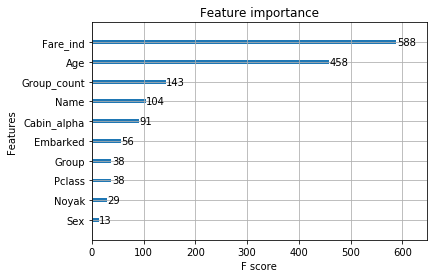

In [187]:
from xgboost import plot_importance
plot_importance(xgc)

In [188]:
xgc.score

<bound method ClassifierMixin.score of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, gamma=0.5, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=400, n_jobs=1, nthread=None,
              objective='binary:logistic', random_seed=0, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1)>

In [160]:
# Mean-Imputed Categorical Age Model
train_X_2 =  train_X
train_X_2['Age'] = train_X_2['Age'].apply(lambda x: 0 if x < 17 else(0 if x >49 else 1))
train_X_2

,Pclass,Name,Sex,Age,Embarked,Cabin_alpha,Group,Group_count,Fare_ind
0,3,2,1,1,2,7,True,2,3.625000
1,1,3,0,1,0,2,True,2,35.641650
2,3,1,0,1,2,7,False,1,7.925000
3,1,3,0,1,2,2,True,2,26.550000
4,3,2,1,1,2,7,False,1,8.050000
5,3,2,1,1,1,7,False,1,8.458300
6,1,2,1,0,2,4,False,1,51.862500
7,3,0,1,0,2,7,True,5,4.215000
8,3,3,0,1,2,7,True,3,3.711100
9,2,3,0,0,0,7,True,2,15.035400


In [161]:
xg = xgb.XGBClassifier(random_seed=0,n_estimators=400)
parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1]
        }
clf = RandomizedSearchCV(xg, parameters,n_iter=100, cv=5,random_state=0)
clf.fit(train_X_2, train_y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=400,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_seed=0, random_state=0,
                                           reg_alpha=0, reg_...
                                           silent=True, subsample=1),
                   iid='warn', n_iter=100, n_jobs=None,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                  

In [162]:
print(clf.best_params_)
print(clf.best_score_)

{'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.8}
0.8372615039281706


In [23]:
train[~train['Cabin'].isnull()].Cabin.unique()

array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30',
       'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22',
       'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
       'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126',
       'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64',
       'E24

In [27]:
train[train['Pclass']==1].Survived.value_counts()

1    136
0     80
Name: Survived, dtype: int64

In [35]:
df_train.groupby(['Survived']).mean()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_alpha,Family_size,dup_count,Group,Group_count,Fare_ind
Survived,,,,,,,,,,,,,,
0,447.016393,2.531876,0.852459,30.415100,0.553734,0.329690,22.117887,1.641166,6.426230,1.883424,1.746812,0.386157,2.021858,12.054411
1,444.368421,1.950292,0.318713,28.549778,0.473684,0.464912,48.395408,1.356725,5.175439,1.938596,1.853801,0.634503,2.233918,20.936435


In [46]:
df_train.groupby(['Pclass','Embarked']).describe()

PassengerId                                                \
                      count        mean         std    min     25%    50%   
Pclass Embarked                                                             
1      0               87.0  440.919540  243.405644    2.0  266.50  453.0   
       1                2.0  329.500000  118.086832  246.0  287.75  329.5   
       2              127.0  477.842520  249.989537    4.0  273.50  493.0   
2      0               17.0  444.352941  297.394507   10.0  182.00  390.0   
       1                3.0  418.000000  181.248448  304.0  313.50  323.0   
       2              164.0  446.634146  248.088942   16.0  234.50  439.0   
3      0               66.0  451.484848  277.967305   20.0  205.00  483.0   
       1               72.0  420.347222  259.844545    6.0  198.50  400.5   
       2              353.0  440.685552  263.352933    1.0  201.00  432.0   

                               Survived            ... Group_count        \
                    75%    max    count      mean  ...         75%   max   
Pclass Embarked                                    ...                     
1      0         637.50  890.0     87.0  0.701149  ...        3.00   5.0   
       1         371.25  413.0      2.0  0.500000  ...        2.75   3.0   
       2         698.50  888.0    127.0  0.582677  ...        3.00   6.0   
2      0         686.00  875.0     17.0  0.529412  ...        3.00   4.0   
       1         475.00  627.0      3.0  0.666667  ...        1.00   1.0   
       2         668.00  887.0    164.0  0.463415  ...        3.00   6.0   
3      0         693.50  876.0     66.0  0.378788  ...        2.00   4.0   
       1         654.25  891.0     72.0  0.375000  ...        2.00   6.0   
       2         668.00  889.0    353.0  0.189802  ...        3.00  11.0   

                Fare_ind                                              \
                   count       mean        std        min        25%   
Pclass Embarked                                                        
1      0            87.0  45.409578  30.259151  14.850000  28.588550   
       1             2.0  37.500000  10.606602  30.000000  33.750000   
       2           127.0  32.944412  21.158412   0.000000  26.282300   
2      0            17.0  12.549366   2.185885   6.929150  12.000000   
       1             3.0  12.350000   0.000000  12.350000  12.350000   
       2           164.0  11.004243   3.675578   0.000000   9.750000   
3      0            66.0   6.717735   1.384601   2.409733   5.825012   
       1            72.0   7.445719   1.477129   2.583333   7.733300   
       2           353.0   7.178502   2.026679   0.000000   6.322727   

                                                
                       50%      75%        max  
Pclass Embarked                                 
1      0         37.758333  49.5042  170.77640  
       1         37.500000  41.2500   45.00000  
       2         28.500000  37.8875  221.77920  
2      0         12.334733  13.8625   15.05000  
       1         12.350000  12.3500   12.35000  
       2         12.587500  13.0000   26.00000  
3      0          7.227100   7.2292    9.39375  
       1          7.750000   7.7500   15.50000  
       2          7.795800   8.0500   22.52500  

[9 rows x 96 columns]

In [41]:
test = pd.read_csv("test.csv")

# Age 변수 결측치 처리

In [52]:
# Age 결측치 처리를 위해 다른 컬럼에서 Age를 예측하도록 해볼까?
# 어떤 변수가 Age와 연관성이 높은지 보자
train[~train['Age'].isnull()].corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,0.029340,-0.035349,0.036847,-0.082398,-0.011617,0.009592
Survived,0.029340,1.000000,-0.359653,-0.077221,-0.017358,0.093317,0.268189
Pclass,-0.035349,-0.359653,1.000000,-0.369226,0.067247,0.025683,-0.554182
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.082398,-0.017358,0.067247,-0.308247,1.000000,0.383820,0.138329
Parch,-0.011617,0.093317,0.025683,-0.189119,0.383820,1.000000,0.205119
Fare,0.009592,0.268189,-0.554182,0.096067,0.138329,0.205119,1.000000


In [54]:
age_train = train[~train['Age'].isnull()]
age_test = train[train['Age'].isnull()]

In [56]:
age_X = age_train.drop(['PassengerId','Age','Name','Sex','Ticket'],axis=1)
age_y = age_train.Age

In [58]:
age_X.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

In [57]:
xgr = xgb.XGBRegressor(random_seed=0,n_estimators=400)
parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1]
        }
clf = RandomizedSearchCV(xgr, parameters,n_iter=100, cv=5)
clf.fit(age_X, age_y)

/Users/danielhan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Name, Sex, Ticket, Cabin, Embarked

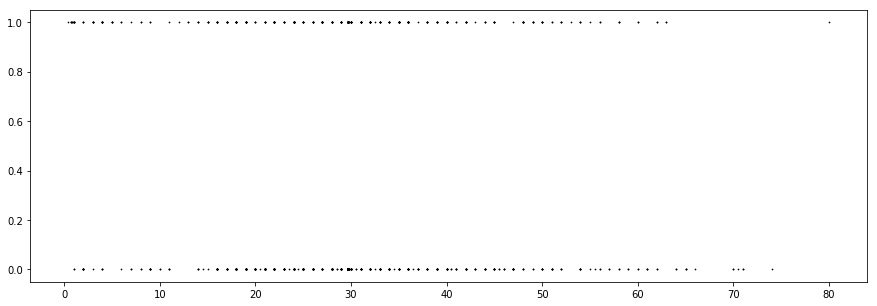

In [96]:
plt.figure(figsize=(15,5))
plt.plot(df_train.Age, df_train.Survived,'o',color='black',markersize=0.7)

plt.show()